In [8]:
#First, import proper libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [9]:
%pwd

'/Users/kylecamlic'

In [10]:
os.chdir ('/Users/kylecamlic/Documents') #change working directory to the correct directory to analyze .csv files
%pwd

'/Users/kylecamlic/Documents'

In [11]:
#lets define our two csv files
df_train1 = pd.read_csv('train.csv')
df_test1 = pd.read_csv('test.csv')

In [12]:
df_train1.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,churn,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,state,area_code,phone
0,56.5,0.26,322.2,194.3,126,1,0,0,1,3,2,4,Male,False,True,MS,510,402-5509
1,84.0,0.46,279.1,170.9,92,0,0,0,1,2,2,3,Male,False,False,OH,510,370-3021
2,96.0,0.00,294.7,306,96,1,1,0,0,2,3,3,Female,True,False,MI,415,373-1448
3,62.0,0.00,255.4,185.6,100,2,0,0,0,2,2,3,Male,False,False,VT,510,403-1769
4,45.0,0.28,300.6,197.9,154,0,0,0,1,3,2,5,Male,False,True,WV,408,405-9384


In [13]:
#How many rows and columns?
df_train1.shape

(2666, 18)

In [14]:
#we should always check for missing values in our data 
df_train1.isna().sum()

last_purchase      0
max_discount       1
shoe_spend         0
apparell_spend     0
acc_spend          0
custserv_calls     0
churn              0
acc_purchasers     0
promo_purchaser    0
shoe_orders        0
apparel_orders     0
acc_orders         0
gender             0
ecommShopper       0
bhShopper          0
state              0
area_code          0
phone              0
dtype: int64

In [15]:
#also important to check your data types
df_train1.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend      object
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
state               object
area_code            int64
phone               object
dtype: object

In [16]:
#it is interesting that our apparell_spend column is an object dtype, would be better if this 
#column was numeric
pd.to_numeric(df_train1.apparell_spend)

ValueError: Unable to parse string "a" at position 707

In [ ]:
#we get an error that says there is an 'a' string at position 707
#since this is only the case for 1 row, it would be most efficient to delete this row
df_train1.iloc[707]['apparell_spend']


In [27]:
#delete the position 707 row 'a' in the max_discount column
df_train2 = df_train1[df_train1.apparell_spend!='a']
df_train2.shape

(2665, 18)

In [28]:
#we see this was done successful because we have 1 less row in the shape of this dataframe
#now before we model lets look at our data to make some observations

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='churn', ylabel='count'>

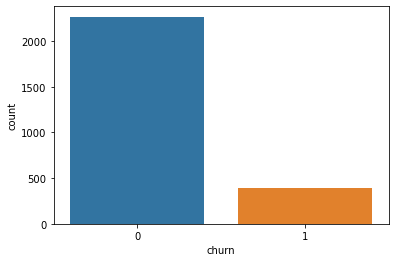

In [29]:
#our target variable is churn so lets look at this visualize this variable
sns.countplot(df_train2['churn'])

In [30]:
#We see that obviously Under Armour is retaining more customers than are leaving (by a significant margin)
#But we may wonder, Exactly how many churned? and What are the exact percentages of churning and staying customers?

#find the number of customers who churned/didn't churn
total_customers_kept = df_train2[df_train2.churn == 0].shape[0]
total_customers_churned = df_train2[df_train2.churn == 1].shape[0]

#print these numbers
print(total_customers_kept)
print(total_customers_churned)

#figure out the percentage of customers who stayed and the percentage who left
percentage_kept = ((total_customers_kept / (total_customers_kept + total_customers_churned))*100)
percentage_churned = ((total_customers_churned / (total_customers_kept + total_customers_churned))*100)

#print this data
print(percentage_kept, '% of customers stayed with Under Armour')
print(percentage_churned, '% of customers left Under Armour' )

2268
397
85.10318949343339 % of customers stayed with Under Armour
14.896810506566604 % of customers left Under Armour


<AxesSubplot:xlabel='gender', ylabel='count'>

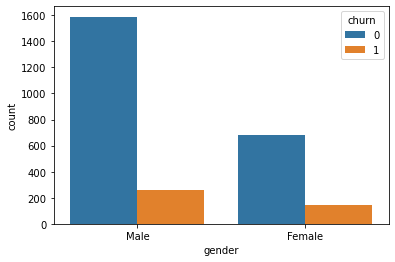

In [31]:
#We may also wonder things like: does gender play a significant role in churn? 
#Do we need to increase our efforts to market to one gender in particular? Let's see:
sns.countplot(x = 'gender', hue='churn', data=df_train2)

In [32]:
#Here we see that gender does not really seem to play a big role in why customers are leaving

<AxesSubplot:xlabel='custserv_calls', ylabel='count'>

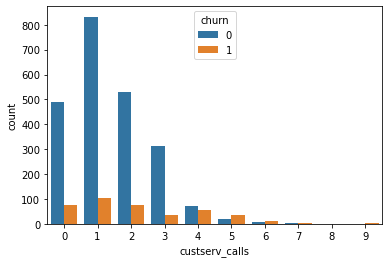

In [33]:
#One column that comes to mind that may influence churn rate is custserv_calls
#typically a lot of customer service calls is an indication that a customer
#is not all that happy with their service or product quality which leads to higher churn rates
#lets look at this:
sns.countplot(x='custserv_calls', hue='churn', data=df_train2)

In [34]:
#As expected churn rates increase substansially as custserv_calls also increase.
#And really we see that by the fourth customer service call, around 50% of customers end up leaving
#This is HUGE and if we can prevent this we can save a lot of customers from leaving
#let's look at this in even more depth:
Cust_at_least_four_calls = df_train2[df_train2.custserv_calls >= 4].shape[0]
Cust_less_than_four_calls = df_train2[df_train2.custserv_calls < 4].shape[0]

print(Cust_at_least_four_calls)
print(Cust_less_than_four_calls)

207
2458


In [35]:
#So we see that 207 total customers have made at least 4 custserv_calls
#Let's see how many customers WITH AT LEAST 4 custserv_calls churn
df_train2[df_train2.custserv_calls >= 4][df_train2.churn == 1]

<ipython-input-35-d1d453672fd2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train2[df_train2.custserv_calls >= 4][df_train2.churn == 1]


,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,churn,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,state,area_code,phone
38,41.0,0.00,397.9,287.8,54,4,1,0,0,3,3,2,Female,False,True,NY,415,351-7269
118,104.0,0.00,203.1,128.2,103,5,1,0,0,2,2,3,Female,False,True,NH,408,393-8762
120,63.5,0.00,224.4,149.5,97,6,1,0,0,2,2,3,Male,True,True,MD,408,405-2276
184,77.5,0.00,196.5,144.8,79,5,1,0,0,2,2,3,Male,False,True,WV,510,421-1326
191,79.0,0.00,230.8,160,109,5,1,0,0,2,2,3,Female,True,False,MO,510,383-6095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,60.0,0.00,188.2,160,129,4,1,0,0,2,2,4,Female,True,True,NY,415,329-6731
2624,72.0,0.00,180.5,188.1,115,7,1,0,0,1,2,4,Male,True,False,VT,415,380-8727
2633,76.0,0.00,219.4,138.3,117,5,1,0,0,2,2,4,Female,False,True,MI,415,390-7930
2662,71.0,0.00,154.7,230.1,135,5,1,0,0,1,3,4,Male,False,False,OK,408,345-1524


In [36]:
#We see that 106 of the total 207 customers with at least 4 customer services calls have churned
Cust_churn_rate_more_than_four_calls = (106/207)*100
print(Cust_churn_rate_more_than_four_calls, '% of customers that have at least four calls churn')

51.20772946859904 % of customers that have at least four calls churn


In [37]:
#this is astoundingly high compared to our normal churn rate of around 14%
#This may be an indication that we should make our custserv process easier or more efficient if possible

array([<AxesSubplot:title={'center':'max_discount'}>,
       <AxesSubplot:title={'center':'shoe_spend'}>], dtype=object)

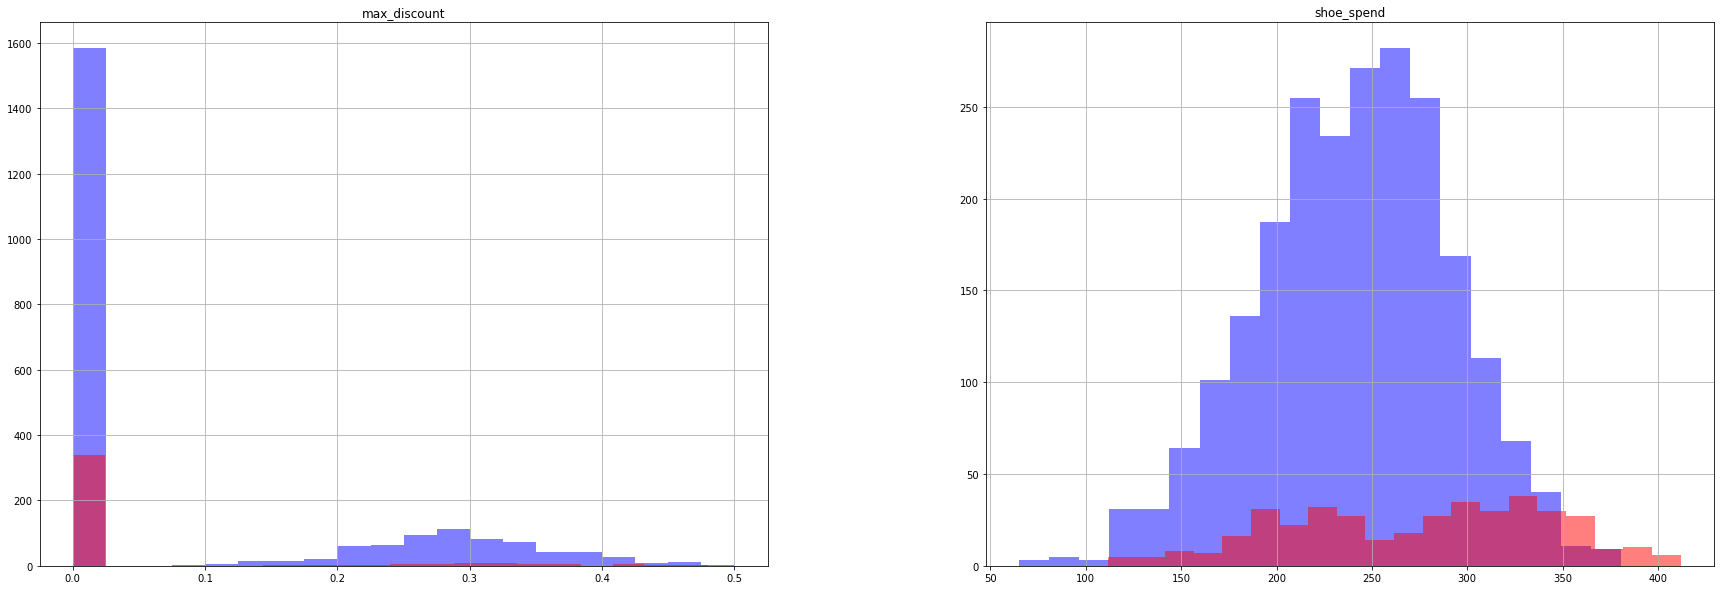

In [38]:
#we can also look at other columns and see how/if they impact churn rates
other_cols = ['max_discount', 'shoe_spend']
fig, ax = plt.subplots(1,2, figsize=(30,10))
df_train2[df_train2.churn == 0][other_cols].hist(bins=20, color='blue', alpha=0.5, ax=ax)
df_train2[df_train2.churn == 1][other_cols].hist(bins=20, color='red', alpha=0.5, ax=ax)

<function matplotlib.pyplot.legend(*args, **kwargs)>

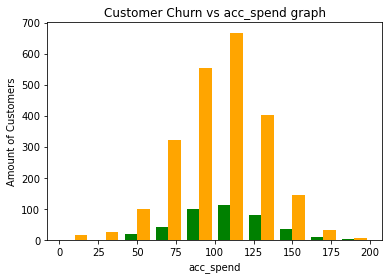

In [39]:
#we also see here the shoe_spend has a big impact on customers churning as well
#lets look at the account spend column
#sometimes a lot of money spent could be a good thing, 
#but this isn't always the case, especially if there are recurring fees
acc_spend_no_churn = df_train2[df_train2.churn==0].acc_spend
acc_spend_yes_churn = df_train2[df_train2.churn==1].acc_spend

plt.xlabel('acc_spend')
plt.ylabel('Amount of Customers')
plt.title('Customer Churn vs acc_spend graph')


plt.hist([acc_spend_yes_churn, acc_spend_no_churn], color=['green', 'orange'], label=['churn=1', 'churn=0'])
plt.legend

In [40]:
#It seems that acc_spend has an impact on our churn rates, but not more than some other variables

In [41]:
#Ideally our data types will all be numeric to be able to model and make predictions

In [42]:
df_train2.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend      object
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
state               object
area_code            int64
phone               object
dtype: object

In [43]:
#We should also take off columns that are not important for making predicitions that are non-numeric
df_train2 = df_train2.drop(['state', 'area_code', 'phone'], axis=1)
#Also converting dtypes to be numeric for modeling purposes
df_train2.apparell_spend = pd.to_numeric(df_train2.apparell_spend)

In [44]:
df_train2.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
dtype: object

In [45]:
#We should now get the gender, ecommshopper, and bhshopper columns to be int dtype
#for boolean values we have the obvious conversion False=0, True=1
#For gender we will replace Male=1, and Female=0 to make our model

df_train2['ecommShopper'].replace('True', 1, inplace=True)
df_train2['ecommShopper'].replace('False', 0, inplace=True)
df_train2['bhShopper'].replace('True', 1, inplace=True)
df_train2['bhShopper'].replace('False', 0, inplace=True)

df_train2.replace('Male', 1, inplace=True)
df_train2.replace('Female', 0, inplace=True)

In [46]:
#Let's look at the dtypes again
df_train2.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender               int64
ecommShopper          bool
bhShopper             bool
dtype: object

In [47]:
#change ecommShopper and bhShopper to int dtypes
df_train2['ecommShopper'] = df_train2['ecommShopper'].astype(int)
df_train2['bhShopper'] = df_train2['bhShopper'].astype(int)

In [48]:
df_train2.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender               int64
ecommShopper         int64
bhShopper            int64
dtype: object

In [49]:
#We now have all float or int dtypes
#We should also clean our test.csv so we can make predictions from it

In [50]:
df_test1.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,state,area_code,phone
0,57.5,0.25,330.1,167.4,100,1,0,1,3,2,3,Male,True,True,KS,415,382-4657
1,84.0,0.00,231.7,118.3,101,3,1,0,2,2,3,Male,False,True,OK,415,330-6626
2,89.0,0.00,194.1,198.5,127,4,0,0,2,2,4,Male,False,True,IN,415,329-6603
3,56.5,0.00,248.0,42.9,95,0,0,0,2,1,3,Male,False,True,AZ,415,358-1958
4,66.0,0.00,175.4,107.3,77,2,0,0,1,2,3,Female,False,True,SC,415,350-2565


In [51]:
#We have analyzed how different values do/don't impact churn in our train.csv, so lets just clean our test.csv
df_test1.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
state               object
area_code            int64
phone               object
dtype: object

In [52]:
#As before, to model we should drop unimportant columns, especially ones that cannot be numeric
df_test1 = df_test1.drop(['state', 'area_code', 'phone'], axis=1)

In [53]:
df_test1.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
dtype: object

In [54]:
#As with train.csv, we should make boolean 0 and 1 and replace Male with 1 and Female with 0
df_test1['ecommShopper'].replace('True', 1, inplace=True)
df_test1['ecommShopper'].replace('False', 0, inplace=True)
df_test1['bhShopper'].replace('True', 1, inplace=True)
df_test1['bhShopper'].replace('False', 0, inplace=True)

df_test1.replace('Male', 1, inplace=True)
df_test1.replace('Female', 0, inplace=True)

df_test1['ecommShopper'] = df_test1['ecommShopper'].astype(int)
df_test1['bhShopper'] = df_test1['bhShopper'].astype(int)

In [55]:
df_test1.dtypes

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend     float64
acc_spend            int64
custserv_calls       int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender               int64
ecommShopper         int64
bhShopper            int64
dtype: object

In [56]:
#check to make sure we still have no null values
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   last_purchase    667 non-null    float64
 1   max_discount     667 non-null    float64
 2   shoe_spend       667 non-null    float64
 3   apparell_spend   667 non-null    float64
 4   acc_spend        667 non-null    int64  
 5   custserv_calls   667 non-null    int64  
 6   acc_purchasers   667 non-null    int64  
 7   promo_purchaser  667 non-null    int64  
 8   shoe_orders      667 non-null    int64  
 9   apparel_orders   667 non-null    int64  
 10  acc_orders       667 non-null    int64  
 11  gender           667 non-null    int64  
 12  ecommShopper     667 non-null    int64  
 13  bhShopper        667 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 73.1 KB


In [57]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 0 to 2665
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   last_purchase    2665 non-null   float64
 1   max_discount     2664 non-null   float64
 2   shoe_spend       2665 non-null   float64
 3   apparell_spend   2665 non-null   float64
 4   acc_spend        2665 non-null   int64  
 5   custserv_calls   2665 non-null   int64  
 6   churn            2665 non-null   int64  
 7   acc_purchasers   2665 non-null   int64  
 8   promo_purchaser  2665 non-null   int64  
 9   shoe_orders      2665 non-null   int64  
 10  apparel_orders   2665 non-null   int64  
 11  acc_orders       2665 non-null   int64  
 12  gender           2665 non-null   int64  
 13  ecommShopper     2665 non-null   int64  
 14  bhShopper        2665 non-null   int64  
dtypes: float64(4), int64(11)
memory usage: 413.1 KB


In [58]:
#here our target column is churn, so this is our y value
X = df_train2.drop(['churn'], axis=1)
y = df_train2['churn']



In [62]:
#split the train.csv into training and testing to find accuracy of our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [65]:
#We will use Random Forest model because it is usually very accurate 
#and can take in a large amount of predictor variables
#Random forest also makes no assumptions about data distribution and is good for churn, (as the name suggests)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, random_state=0)
classifier.fit(X_train, y_train)
predictions1 = classifier.predict(X_test)

In [66]:
#here we are predicting our values for the churn column of train.csv to assess the accuracy of our model
print(predictions1)

[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 1 0 1 0 

In [67]:
#Lets assess our model accuracy before we apply it to our test.csv
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predictions1))
print(accuracy_score(y_test, predictions1))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       454
           1       0.91      0.62      0.74        79

    accuracy                           0.93       533
   macro avg       0.92      0.80      0.85       533
weighted avg       0.93      0.93      0.93       533

0.9343339587242027


In [ ]:
#Our model has an accuracy of 93%, which is much better than just guessing,
#(we could get 85.10318949343339 percent of our predictions right if we just guess 0 every time for perspective)

#precision is high for our 0 churn values as was recall, meaning it was good about not just assigning
#all values of our predictions to 0

#for 1, our precision was still good, but recall and f1-score was low, meaning our classifier is missing too many 
#churn values of 1, (it is essentially be to careful with predictions of 1)

#overall the accuracy is very good

In [68]:
#Now that we see our model is good, lets apply it to our test.csv and make predictions
#here we wont use train_test_split because we already have the training and testing csv files seperate
X_train = df_train2.drop('churn', axis=1)
y_train = df_train2['churn']

#get rid of inf or nan values in X_train
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [69]:
#here we are given our test vales in a test.csv, no need to split
X_test = df_test1

In [70]:
#lets run the same model on our test data for final prediction
classifier_test = RandomForestClassifier(n_estimators=200, random_state=0)
classifier_test.fit(X_train, y_train)
y_pred_test = classifier_test.predict(X_test)

In [71]:
#print test predictions for churn column that we will add on to the dataframe
print(y_pred_test)

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 

<AxesSubplot:>

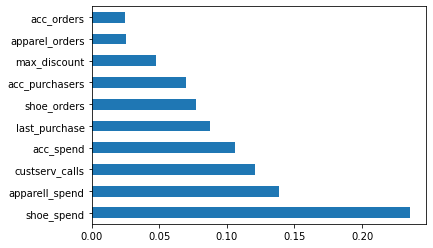

In [72]:
#now we may also wonder which variables play the most signifcant role in predicting customer churn
#As the analysis before indicated, we DO NOT want customers to be making 4 or more custserv_calls because
#then they leave more than 50% of the time
#so lets look at this:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')


In [73]:
#As expected custserv_calls is pretty high up on our feature importance, and we also see that apparell_orders, 
# and acccount orders do not have much of an impact
#We also see that shoe_spend is very important when it comes to predicting churn, as is apparell_spend


In [74]:
#now lets add our predicitions to our test df and store it as a csv file
df_test_RF_pred = df_test1.assign(Churn=y_pred_test)

In [75]:
#lets look at this new df to make sure we have input our new values for churn predictions
df_test_RF_pred.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,Churn
0,57.5,0.25,330.1,167.4,100,1,0,1,3,2,3,1,1,1,0
1,84.0,0.00,231.7,118.3,101,3,1,0,2,2,3,1,0,1,0
2,89.0,0.00,194.1,198.5,127,4,0,0,2,2,4,1,0,1,1
3,56.5,0.00,248.0,42.9,95,0,0,0,2,1,3,1,0,1,0
4,66.0,0.00,175.4,107.3,77,2,0,0,1,2,3,0,0,1,0


In [76]:
#and lets save this df as a new csv file
df_test_RF_pred.to_csv('Random_Forest_predictions_test.csv')

In [77]:
%pwd

'/Users/kylecamlic/Documents'

In [78]:
df_test1.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper
0,57.5,0.25,330.1,167.4,100,1,0,1,3,2,3,1,1,1
1,84.0,0.00,231.7,118.3,101,3,1,0,2,2,3,1,0,1
2,89.0,0.00,194.1,198.5,127,4,0,0,2,2,4,1,0,1
3,56.5,0.00,248.0,42.9,95,0,0,0,2,1,3,1,0,1
4,66.0,0.00,175.4,107.3,77,2,0,0,1,2,3,0,0,1


In [86]:
#test_csv_final = pd.read_csv('test.csv')

In [87]:
#test_csv_final.head()

In [88]:
#test_csv_final = test_csv_final.assign(Churn=y_pred_test)

In [89]:
#test_csv_final.head()

In [90]:
#forgot to add back the state, area code, and phone columns
RF_pred_final = pd.read_csv('test.csv')

In [91]:
RF_pred_final.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,state,area_code,phone
0,57.5,0.25,330.1,167.4,100,1,0,1,3,2,3,Male,True,True,KS,415,382-4657
1,84.0,0.00,231.7,118.3,101,3,1,0,2,2,3,Male,False,True,OK,415,330-6626
2,89.0,0.00,194.1,198.5,127,4,0,0,2,2,4,Male,False,True,IN,415,329-6603
3,56.5,0.00,248.0,42.9,95,0,0,0,2,1,3,Male,False,True,AZ,415,358-1958
4,66.0,0.00,175.4,107.3,77,2,0,0,1,2,3,Female,False,True,SC,415,350-2565


In [92]:
RF_pred_final = RF_pred_final.assign(Churn=y_pred_test)

In [93]:
RF_pred_final.head()

,last_purchase,max_discount,shoe_spend,apparell_spend,acc_spend,custserv_calls,acc_purchasers,promo_purchaser,shoe_orders,apparel_orders,acc_orders,gender,ecommShopper,bhShopper,state,area_code,phone,Churn
0,57.5,0.25,330.1,167.4,100,1,0,1,3,2,3,Male,True,True,KS,415,382-4657,0
1,84.0,0.00,231.7,118.3,101,3,1,0,2,2,3,Male,False,True,OK,415,330-6626,0
2,89.0,0.00,194.1,198.5,127,4,0,0,2,2,4,Male,False,True,IN,415,329-6603,1
3,56.5,0.00,248.0,42.9,95,0,0,0,2,1,3,Male,False,True,AZ,415,358-1958,0
4,66.0,0.00,175.4,107.3,77,2,0,0,1,2,3,Female,False,True,SC,415,350-2565,0


In [94]:
df_test_RF_pred.to_csv('RF_pred_final.csv')

In [96]:
RF_pred_final.to_csv('UA_final_pred.csv')

In [97]:
%pwd

'/Users/kylecamlic/Documents'